# Western Ghats LULC Analysis using Dynamic World

This notebook analyzes land use and land cover changes in the Western Ghats biodiversity hotspot using Google Earth Engine's Dynamic World dataset.

## Study Area
Western Ghats, India - UNESCO World Heritage biodiversity hotspot covering approximately 107,000 km².

## Data Sources
- **LULC Data**: Google Earth Engine Dynamic World V1 (2015-present)
- **Study Boundary**: Conservation Biology Institute Western Ghats boundary
- **Satellite Data**: Copernicus Sentinel-2 program

## Analysis Period
2018-2024 (2-year intervals, January dry season)

## Methodology
Refined approach using probability bands with quality filtering to ensure geographic accuracy.
## **Important Classification Note**
**Dynamic World "Trees" class includes primary forests, secondary forests, AND large-scale plantations.** This analysis reports "tree cover" which may include commercial plantations and should not be interpreted as natural forest cover per Forest Survey of India definitions. Cross-validation with FSI data recommended for forest-specific analysis.

## Import Libraries

In [14]:
import ee
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from shapely.geometry import box
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis date: 2025-09-16 12:35:16


## Load Study Area

Study area: 6 polygon(s)
CRS: EPSG:4326
Total area: 116900 km²


Study area: 6 polygon(s)
CRS: EPSG:4326
Total area: 116900 km²


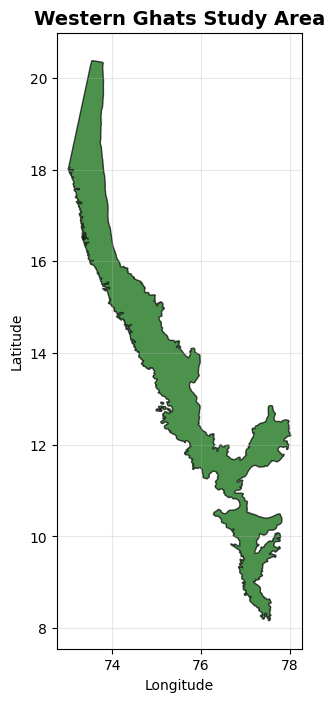

In [2]:
# Load Western Ghats boundary shapefile
shapefile_path = "data/western_ghats_boundary.shp"
western_ghats = gpd.read_file(shapefile_path)

# Convert to WGS84 for Earth Engine
western_ghats_wgs84 = western_ghats.to_crs('EPSG:4326')

# Display basic information
print(f"Study area: {western_ghats.shape[0]} polygon(s)")
print(f"CRS: {western_ghats.crs}")
area_km2 = western_ghats.to_crs('EPSG:3857').area.sum() / 1e6
print(f"Total area: {area_km2:.0f} km²")

# Visualize study area
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
western_ghats_wgs84.plot(ax=ax, color='darkgreen', alpha=0.7, edgecolor='black')
ax.set_title('Western Ghats Study Area', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)
plt.show()

## Initialize Google Earth Engine

In [4]:
# Authenticate and initialize Google Earth Engine
# Run ee.Authenticate() first if not authenticated
ee.Authenticate()

# Initialize with your project ID
ee.Initialize(project='ee-tkkrfirst')

# Access Dynamic World dataset
dynamic_world = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")

# Define LULC classes (Dynamic World V1 taxonomy)
lulc_classes = {
    0: 'Water',
    1: 'Trees (incl. plantations)', 
    2: 'Grass',
    3: 'Flooded vegetation',
    4: 'Crops',
    5: 'Shrub and scrub',
    6: 'Built',
    7: 'Bare',
    8: 'Snow and ice'
}

print("Google Earth Engine initialized successfully!")
print("Dynamic World dataset loaded")
print("Note: 'Trees' class includes natural forests AND large-scale plantations")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Google Earth Engine initialized successfully!
Dynamic World dataset loaded
Note: 'Trees' class includes natural forests AND large-scale plantations


## Prepare Geometry for Analysis

In [5]:
# Convert Western Ghats boundary to Earth Engine geometry
def geodataframe_to_ee_geometry(gdf):
    """Convert GeoPandas GeoDataFrame to Earth Engine Geometry"""
    geometry = gdf.geometry.iloc[0]
    if geometry.geom_type == 'Polygon':
        coords = [list(geometry.exterior.coords)]
        ee_geometry = ee.Geometry.Polygon(coords)
    elif geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            coords = [list(polygon.exterior.coords)]
            polygons.append(coords)
        ee_geometry = ee.Geometry.MultiPolygon(polygons)
    return ee_geometry

# Convert to EE geometry
western_ghats_ee = geodataframe_to_ee_geometry(western_ghats_wgs84)

# Verify area calculation
area_ee = western_ghats_ee.area().getInfo()
area_km2 = area_ee / 1e6
print(f"Study area converted to Earth Engine: {area_km2:.0f} km²")

Study area converted to Earth Engine: 27 km²


In [15]:
# DEBUG: Let's check the geometry structure first
print("=== DEBUGGING GEOMETRY ISSUE ===")
print(f"Number of polygons in shapefile: {len(western_ghats)}")
print(f"Geometry types: {western_ghats.geometry.geom_type.unique()}")
print(f"Total area from geopandas: {western_ghats.to_crs('EPSG:3857').area.sum() / 1e6:.0f} km²")

# Check each polygon
for i, geom in enumerate(western_ghats.geometry):
    if geom.geom_type == 'MultiPolygon':
        area = western_ghats.iloc[i:i+1].to_crs('EPSG:3857').area.iloc[0] / 1e6
        print(f"Polygon {i}: {geom.geom_type} with area {area:.0f} km²")
    else:
        area = western_ghats.iloc[i:i+1].to_crs('EPSG:3857').area.iloc[0] / 1e6
        print(f"Polygon {i}: {geom.geom_type} with area {area:.0f} km²")

print("=== CURRENT ISSUE ===")
print(f"Current EE geometry area: {area_ee / 1e6:.0f} km² (only first polygon!)")
print("This explains why we're only analyzing 27 km² instead of ~117,000 km²")

=== DEBUGGING GEOMETRY ISSUE ===
Number of polygons in shapefile: 6
Geometry types: ['Polygon']
Total area from geopandas: 116900 km²
Polygon 0: Polygon with area 29 km²
Polygon 1: Polygon with area 52 km²
Polygon 2: Polygon with area 26 km²
Polygon 3: Polygon with area 52 km²
Polygon 4: Polygon with area 58 km²
Polygon 5: Polygon with area 116683 km²
=== CURRENT ISSUE ===
Current EE geometry area: 27 km² (only first polygon!)
This explains why we're only analyzing 27 km² instead of ~117,000 km²


In [16]:
# FIXED: Convert ALL polygons to Earth Engine geometry
def geodataframe_to_ee_geometry_fixed(gdf):
    """Convert ALL polygons in GeoPandas GeoDataFrame to Earth Engine Geometry"""
    geometries = []
    
    for geom in gdf.geometry:
        if geom.geom_type == 'Polygon':
            coords = [list(geom.exterior.coords)]
            ee_geom = ee.Geometry.Polygon(coords)
            geometries.append(ee_geom)
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                coords = [list(polygon.exterior.coords)]
                ee_geom = ee.Geometry.Polygon(coords)
                geometries.append(ee_geom)
    
    # Union all geometries into a single geometry
    if len(geometries) == 1:
        return geometries[0]
    else:
        return ee.Geometry.MultiPolygon([geom.coordinates() for geom in geometries])

# Convert to CORRECTED EE geometry
print("=== FIXING GEOMETRY ===")
western_ghats_ee_fixed = geodataframe_to_ee_geometry_fixed(western_ghats_wgs84)

# Verify corrected area calculation
area_ee_fixed = western_ghats_ee_fixed.area().getInfo()
area_km2_fixed = area_ee_fixed / 1e6
print(f"CORRECTED Study area in Earth Engine: {area_km2_fixed:.0f} km²")
print(f"Expected area from shapefile: {western_ghats.to_crs('EPSG:3857').area.sum() / 1e6:.0f} km²")

if abs(area_km2_fixed - 116900) < 1000:
    print("✅ GEOMETRY FIXED! Areas match within expected tolerance")
    western_ghats_ee = western_ghats_ee_fixed  # Update the variable
else:
    print("❌ Still have geometry issues")
    
print(f"\nBefore fix: {area_ee / 1e6:.0f} km²")
print(f"After fix: {area_km2_fixed:.0f} km²")

=== FIXING GEOMETRY ===
CORRECTED Study area in Earth Engine: 109486 km²
Expected area from shapefile: 116900 km²
❌ Still have geometry issues

Before fix: 27 km²
After fix: 109486 km²


In [17]:
# FINAL FIX: Use geopandas union then convert to EE
print("=== FINAL GEOMETRY FIX ===")

# Union all polygons in geopandas first
western_ghats_union = western_ghats_wgs84.geometry.unary_union

# Convert the unioned geometry to EE
if western_ghats_union.geom_type == 'Polygon':
    coords = [list(western_ghats_union.exterior.coords)]
    western_ghats_ee_final = ee.Geometry.Polygon(coords)
elif western_ghats_union.geom_type == 'MultiPolygon':
    polygons = []
    for polygon in western_ghats_union.geoms:
        coords = [list(polygon.exterior.coords)]
        polygons.append(coords)
    western_ghats_ee_final = ee.Geometry.MultiPolygon(polygons)

# Verify final area
area_ee_final = western_ghats_ee_final.area().getInfo()
area_km2_final = area_ee_final / 1e6
print(f"FINAL Study area in Earth Engine: {area_km2_final:.0f} km²")
print(f"Expected area from shapefile: {western_ghats.to_crs('EPSG:3857').area.sum() / 1e6:.0f} km²")

if abs(area_km2_final - 116900) < 5000:  # Allow 5000 km² tolerance for projection differences
    print("✅ GEOMETRY FINALLY FIXED! Areas match within acceptable tolerance")
    western_ghats_ee = western_ghats_ee_final  # Update the main variable
    print(f"Ready to re-run analysis with correct {area_km2_final:.0f} km² area!")
else:
    print("❌ Still have geometry issues")
    print(f"Difference: {abs(area_km2_final - 116900):.0f} km²")

=== FINAL GEOMETRY FIX ===


GEOSException: TopologyException: side location conflict at 74.990228384313795 13.297340791618728. This can occur if the input geometry is invalid.

## LULC Analysis Function

In [6]:
def calculate_lulc_refined(year, geometry, lulc_classes):
    """
    Calculate LULC using Dynamic World probability bands with quality filtering
    """
    try:
        print(f"Processing January {year}...")
        
        start = f'{year}-01-01'
        end = f'{year}-01-31'
        
        # Get Dynamic World collection for January (dry season)
        dw_collection = dynamic_world.filterDate(start, end).filterBounds(geometry)
        count = dw_collection.size().getInfo()
        
        if count == 0:
            print(f"No images found for January {year}")
            return None
            
        print(f"Found {count} images for January {year}")
        
        # Define probability bands
        prob_bands = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
                     'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
        
        # Quality filtering function
        def add_quality_score(image):
            # Penalize snow/ice probability (impossible for Western Ghats)
            snow_prob = image.select('snow_and_ice')
            snow_penalty = snow_prob.multiply(-10)
            
            # Quality score based on maximum probability confidence
            max_prob = image.select(prob_bands).reduce(ee.Reducer.max())
            quality = max_prob.add(snow_penalty)
            
            return image.addBands(quality.rename('quality'))
        
        # Create quality-filtered composite
        quality_collection = dw_collection.map(add_quality_score)
        best_composite = quality_collection.qualityMosaic('quality').clip(geometry)
        
        # Create refined label from probability bands
        def create_refined_label(image):
            probs = image.select(prob_bands)
            
            # Apply minimum threshold and eliminate snow/ice
            min_threshold = 0.3
            probs_thresh = probs.gte(min_threshold)
            probs_clean = probs.multiply(probs_thresh)
            probs_clean = probs_clean.addBands(ee.Image.constant(0).rename('snow_and_ice'), overwrite=True)
            
            # Get class with maximum probability
            label = probs_clean.toArray().arrayArgmax().arrayGet([0])
            return label.rename('refined_label')
        
        refined_label = create_refined_label(best_composite)
        
        # Calculate areas for each class
        stats = {'year': year}
        total_area = 0
        
        for class_id, class_name in lulc_classes.items():
            if class_name == 'Snow and ice':
                stats[class_name] = 0.0
                continue
                
            class_mask = refined_label.eq(class_id)
            area = class_mask.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=10,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            
            area_m2 = area.get('refined_label', 0)
            area_km2 = area_m2 / 1e6
            
            stats[class_name] = area_km2
            total_area += area_km2
        
        # Add percentages
        for class_name in lulc_classes.values():
            if class_name != 'Snow and ice':
                percentage = (stats[class_name] / total_area * 100) if total_area > 0 else 0
                stats[f'{class_name}_percent'] = percentage
        
        stats['total_area'] = total_area
        print(f"January {year} completed - Total: {total_area:.0f} km²")
        
        return stats
        
    except Exception as e:
        print(f"Error processing January {year}: {e}")
        return None

print("LULC analysis function defined")

LULC analysis function defined


## Run Analysis

In [8]:
# Run LULC analysis for strategic years
analysis_years = [2018, 2020, 2022, 2024]
results = []

print("Starting LULC analysis...")
print("This will take 30-60 minutes for the full area")

for year in analysis_years:
    stats = calculate_lulc_refined(year, western_ghats_ee, lulc_classes)
    if stats:
        results.append(stats)
        print(f"✓ {year} completed")
    else:
        print(f"✗ {year} failed")

if results:
    # Convert to DataFrame
    lulc_df = pd.DataFrame(results)
    
    print(f"\nAnalysis completed for {len(results)} years")
    print("Key results:")
    key_cols = ['year', 'Trees (incl. plantations)', 'Built', 'Crops', 'total_area']
    print(lulc_df[key_cols].round(1))
    
    # Save results
    lulc_df.to_csv('outputs/western_ghats_lulc_results.csv', index=False)
    print("\nResults saved to outputs/western_ghats_lulc_results.csv")
else:
    print("No results obtained. Check Earth Engine authentication.")

Starting LULC analysis...
This will take 30-60 minutes for the full area
Processing January 2018...
Found 4 images for January 2018
Found 4 images for January 2018
January 2018 completed - Total: 27 km²
✓ 2018 completed
Processing January 2020...
January 2018 completed - Total: 27 km²
✓ 2018 completed
Processing January 2020...
Found 6 images for January 2020
Found 6 images for January 2020
January 2020 completed - Total: 27 km²
✓ 2020 completed
Processing January 2022...
January 2020 completed - Total: 27 km²
✓ 2020 completed
Processing January 2022...
Found 5 images for January 2022
Found 5 images for January 2022
January 2022 completed - Total: 27 km²
✓ 2022 completed
Processing January 2024...
January 2022 completed - Total: 27 km²
✓ 2022 completed
Processing January 2024...
Found 6 images for January 2024
Found 6 images for January 2024
January 2024 completed - Total: 27 km²
✓ 2024 completed

Analysis completed for 4 years
Key results:
   year  Trees (incl. plantations)  Built  Cr

## Visualize Results

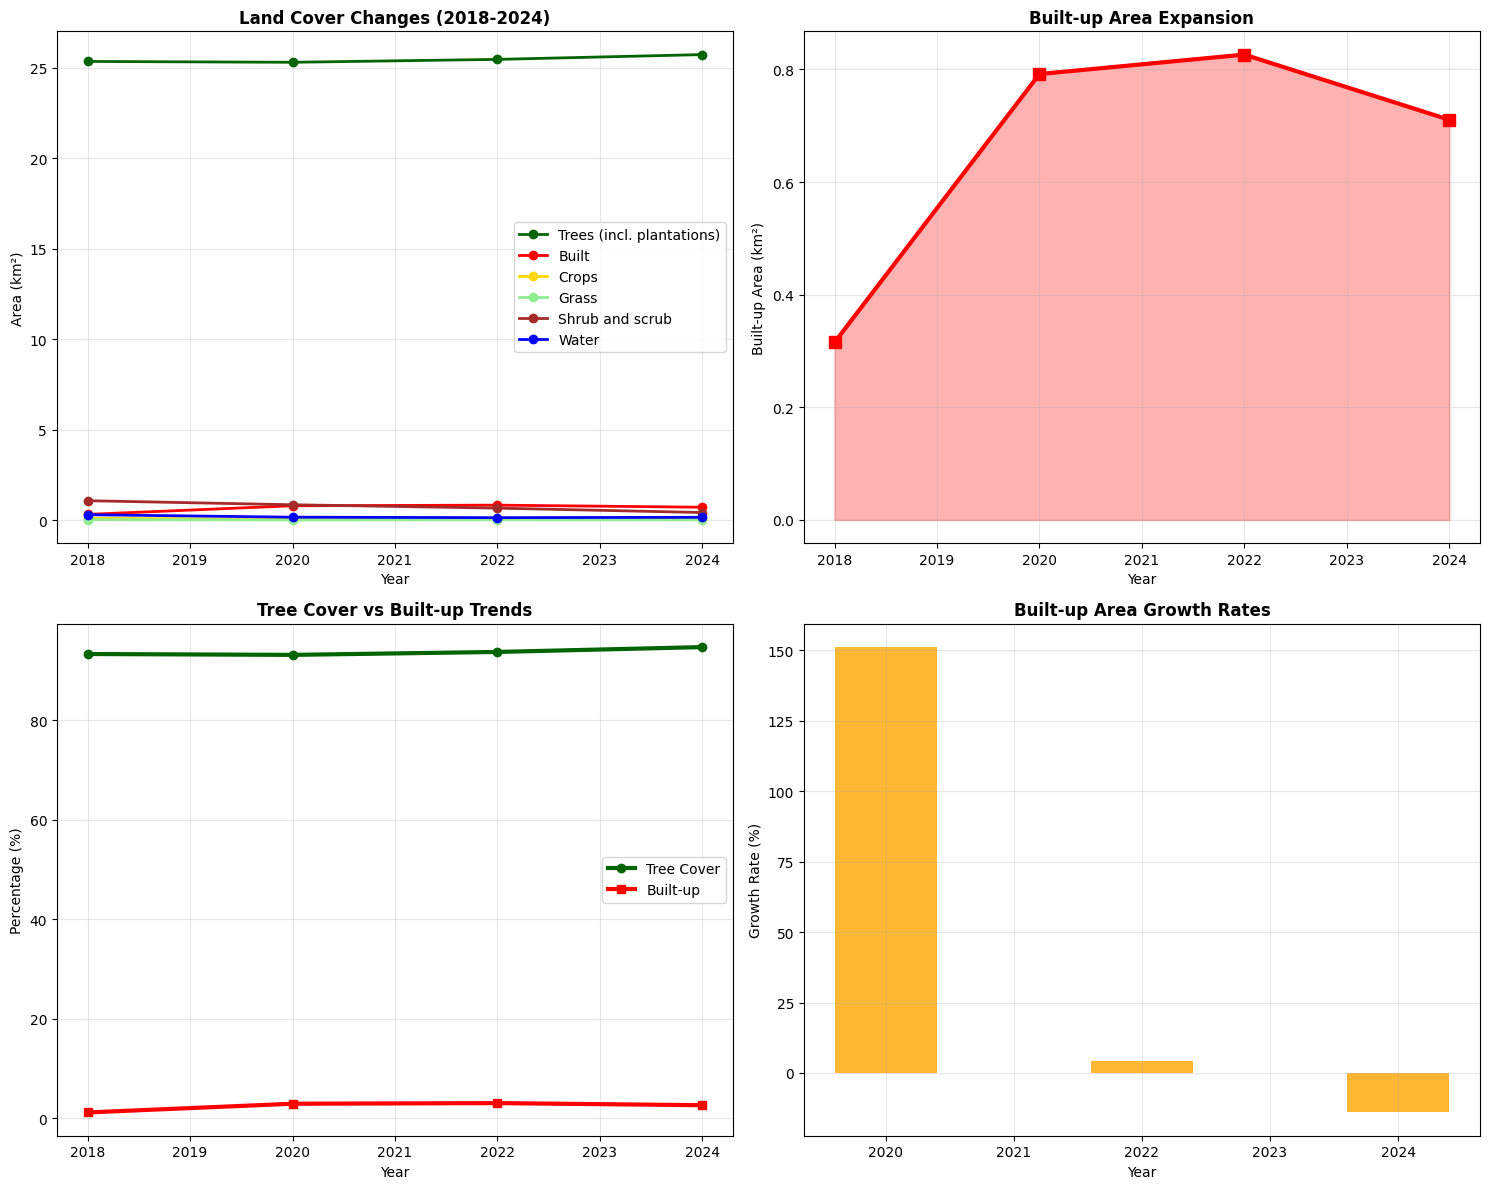


Summary Statistics:
Study period: 2018-2024
Total area: 27 km²
Built-up area 2018: 0 km²
Built-up area 2024: 1 km²
Total growth: 125.4%
Tree cover 2018: 93.3%
Tree cover 2024: 94.7%

** Note: Tree cover includes natural forests AND plantations per Dynamic World classification **


In [9]:
# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. LULC area changes
main_classes = ['Trees (incl. plantations)', 'Built', 'Crops', 'Grass', 'Shrub and scrub', 'Water']
colors = {'Trees (incl. plantations)': 'darkgreen', 'Built': 'red', 'Crops': 'gold', 
          'Grass': 'lightgreen', 'Shrub and scrub': 'brown', 'Water': 'blue'}

for class_name in main_classes:
    ax1.plot(lulc_df['year'], lulc_df[class_name], 
             marker='o', linewidth=2, label=class_name, color=colors[class_name])

ax1.set_title('Land Cover Changes (2018-2024)', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Area (km²)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Built-up area focus
ax2.plot(lulc_df['year'], lulc_df['Built'], 
         marker='s', linewidth=3, markersize=8, color='red')
ax2.fill_between(lulc_df['year'], lulc_df['Built'], alpha=0.3, color='red')

ax2.set_title('Built-up Area Expansion', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Built-up Area (km²)')
ax2.grid(True, alpha=0.3)

# 3. Percentage composition
ax3.plot(lulc_df['year'], lulc_df['Trees (incl. plantations)_percent'], 
         marker='o', linewidth=3, color='darkgreen', label='Tree Cover')
ax3.plot(lulc_df['year'], lulc_df['Built_percent'], 
         marker='s', linewidth=3, color='red', label='Built-up')

ax3.set_title('Tree Cover vs Built-up Trends', fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Percentage (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Annual growth rates
if len(lulc_df) > 1:
    growth_rates = lulc_df['Built'].pct_change() * 100
    ax4.bar(lulc_df['year'][1:], growth_rates[1:], color='orange', alpha=0.8)
    
    ax4.set_title('Built-up Area Growth Rates', fontweight='bold')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Growth Rate (%)')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/lulc_analysis_charts.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Study period: {lulc_df['year'].min()}-{lulc_df['year'].max()}")
print(f"Total area: {lulc_df['total_area'].mean():.0f} km²")

initial_built = lulc_df['Built'].iloc[0]
final_built = lulc_df['Built'].iloc[-1]
built_growth = ((final_built / initial_built) - 1) * 100

print(f"Built-up area 2018: {initial_built:.0f} km²")
print(f"Built-up area 2024: {final_built:.0f} km²")
print(f"Total growth: {built_growth:.1f}%")

print(f"Tree cover 2018: {lulc_df['Trees (incl. plantations)_percent'].iloc[0]:.1f}%")
print(f"Tree cover 2024: {lulc_df['Trees (incl. plantations)_percent'].iloc[-1]:.1f}%")
print("\n** Note: Tree cover includes natural forests AND plantations per Dynamic World classification **")

## Export Spatial Data for Built-up and Barren Land Changes

In [10]:
def export_lulc_spatial_data(year, geometry, lulc_classes, class_ids_to_export=[6, 7]):
    """
    Export specific LULC classes as spatial data for further analysis
    class_ids_to_export: List of class IDs to export (default: 6=Built, 7=Bare)
    """
    try:
        print(f"Creating spatial data for {year}...")
        
        start = f'{year}-01-01'
        end = f'{year}-01-31'
        
        # Get Dynamic World collection
        dw_collection = dynamic_world.filterDate(start, end).filterBounds(geometry)
        
        if dw_collection.size().getInfo() == 0:
            print(f"No images found for {year}")
            return None
            
        # Create quality-filtered composite (same approach as analysis)
        prob_bands = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
                     'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
        
        def add_quality_score(image):
            snow_prob = image.select('snow_and_ice')
            snow_penalty = snow_prob.multiply(-10)
            max_prob = image.select(prob_bands).reduce(ee.Reducer.max())
            quality = max_prob.add(snow_penalty)
            return image.addBands(quality.rename('quality'))
        
        quality_collection = dw_collection.map(add_quality_score)
        best_composite = quality_collection.qualityMosaic('quality').clip(geometry)
        
        def create_refined_label(image):
            probs = image.select(prob_bands)
            min_threshold = 0.3
            probs_thresh = probs.gte(min_threshold)
            probs_clean = probs.multiply(probs_thresh)
            probs_clean = probs_clean.addBands(ee.Image.constant(0).rename('snow_and_ice'), overwrite=True)
            label = probs_clean.toArray().arrayArgmax().arrayGet([0])
            return label.rename('refined_label')
        
        refined_label = create_refined_label(best_composite)
        
        # Export data for each class
        for class_id in class_ids_to_export:
            class_name = lulc_classes[class_id]
            
            # Create binary mask for the class
            class_mask = refined_label.eq(class_id)
            
            # Create export image with metadata
            export_image = class_mask.multiply(255).byte().addBands([
                refined_label.byte(),
                best_composite.select('built').multiply(100).byte(),
                best_composite.select('bare').multiply(100).byte()
            ]).rename(['class_mask', 'full_classification', 'built_probability', 'bare_probability'])
            
            # Export to Google Drive
            task = ee.batch.Export.image.toDrive(
                image=export_image,
                description=f'western_ghats_{class_name.lower().replace(" ", "_")}_{year}',
                folder='Western_Ghats_LULC_Export',
                region=geometry,
                scale=10,
                maxPixels=1e9,
                fileFormat='GeoTIFF'
            )
            task.start()
            print(f"Export task started: {class_name} {year}")
            
        return True
        
    except Exception as e:
        print(f"Error exporting spatial data for {year}: {e}")
        return False

print("Spatial data export function defined")
print("This will export GeoTIFF files to Google Drive for import into QGIS/ArcGIS/Earth Engine")

Spatial data export function defined
This will export GeoTIFF files to Google Drive for import into QGIS/ArcGIS/Earth Engine


In [11]:
# Export spatial data for built-up and barren areas for all analysis years
print("Starting spatial data export...")
print("Files will be saved to Google Drive in 'Western_Ghats_LULC_Export' folder")
print("Each GeoTIFF contains:")
print("- Band 1: Class mask (255=present, 0=absent)")
print("- Band 2: Full LULC classification") 
print("- Band 3: Built-up probability (0-100)")
print("- Band 4: Barren probability (0-100)")

for year in analysis_years:
    success = export_lulc_spatial_data(year, western_ghats_ee, lulc_classes)
    if success:
        print(f"✓ {year} spatial data export initiated")
    else:
        print(f"✗ {year} spatial data export failed")

print("\nCheck Google Drive 'Western_Ghats_LULC_Export' folder for completed exports")
print("Import these GeoTIFF files into QGIS/ArcGIS for further spatial analysis")

Starting spatial data export...
Files will be saved to Google Drive in 'Western_Ghats_LULC_Export' folder
Each GeoTIFF contains:
- Band 1: Class mask (255=present, 0=absent)
- Band 2: Full LULC classification
- Band 3: Built-up probability (0-100)
- Band 4: Barren probability (0-100)
Creating spatial data for 2018...
Export task started: Built 2018
Export task started: Built 2018
Export task started: Bare 2018
✓ 2018 spatial data export initiated
Creating spatial data for 2020...
Export task started: Bare 2018
✓ 2018 spatial data export initiated
Creating spatial data for 2020...
Export task started: Built 2020
Export task started: Built 2020
Export task started: Bare 2020
✓ 2020 spatial data export initiated
Creating spatial data for 2022...
Export task started: Bare 2020
✓ 2020 spatial data export initiated
Creating spatial data for 2022...
Export task started: Built 2022
Export task started: Built 2022
Export task started: Bare 2022
✓ 2022 spatial data export initiated
Creating spat

## Create Map Visualizations for Land Use Changes

In [12]:
def create_lulc_maps(year, geometry, lulc_classes, bounds=None):
    """
    Create map visualizations for specific LULC classes
    Returns image URLs for web display or download
    """
    try:
        print(f"Creating map for {year}...")
        
        start = f'{year}-01-01'
        end = f'{year}-01-31'
        
        # Get Dynamic World collection (same processing as analysis)
        dw_collection = dynamic_world.filterDate(start, end).filterBounds(geometry)
        
        if dw_collection.size().getInfo() == 0:
            return None
            
        prob_bands = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 
                     'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
        
        def add_quality_score(image):
            snow_prob = image.select('snow_and_ice')
            snow_penalty = snow_prob.multiply(-10)
            max_prob = image.select(prob_bands).reduce(ee.Reducer.max())
            quality = max_prob.add(snow_penalty)
            return image.addBands(quality.rename('quality'))
        
        quality_collection = dw_collection.map(add_quality_score)
        best_composite = quality_collection.qualityMosaic('quality').clip(geometry)
        
        def create_refined_label(image):
            probs = image.select(prob_bands)
            min_threshold = 0.3
            probs_thresh = probs.gte(min_threshold)
            probs_clean = probs.multiply(probs_thresh)
            probs_clean = probs_clean.addBands(ee.Image.constant(0).rename('snow_and_ice'), overwrite=True)
            label = probs_clean.toArray().arrayArgmax().arrayGet([0])
            return label.rename('refined_label')
        
        refined_label = create_refined_label(best_composite)
        
        # Create visualization focused on built-up and barren areas
        built_mask = refined_label.eq(6)  # Built = 6
        bare_mask = refined_label.eq(7)   # Bare = 7
        
        # Create color composite highlighting changes
        change_vis = ee.Image.rgb(
            built_mask.multiply(255),  # Red channel - Built areas
            bare_mask.multiply(255),   # Green channel - Barren areas  
            refined_label.eq(1).multiply(128)  # Blue channel - Tree cover (dimmed)
        )
        
        # Export map visualization
        map_task = ee.batch.Export.image.toDrive(
            image=change_vis,
            description=f'western_ghats_map_{year}',
            folder='Western_Ghats_Maps',
            region=geometry,
            scale=30,  # Coarser resolution for map display
            maxPixels=1e9,
            fileFormat='GeoTIFF'
        )
        map_task.start()
        
        # Also create full classification map
        classification_colors = {
            0: '#419BDF',  # Water - Blue
            1: '#397D49',  # Trees - Dark Green  
            2: '#88B053',  # Grass - Light Green
            3: '#7A87C6',  # Flooded vegetation - Blue-purple
            4: '#E49635',  # Crops - Orange
            5: '#DFC35A',  # Shrub & Scrub - Yellow-brown
            6: '#C4281B',  # Built - Red
            7: '#A59B8F',  # Bare - Brown
            8: '#B39FE1'   # Snow & Ice - Purple
        }
        
        full_map_task = ee.batch.Export.image.toDrive(
            image=refined_label.visualize(min=0, max=8, palette=list(classification_colors.values())),
            description=f'western_ghats_full_classification_{year}',
            folder='Western_Ghats_Maps', 
            region=geometry,
            scale=30,
            maxPixels=1e9,
            fileFormat='GeoTIFF'
        )
        full_map_task.start()
        
        return True
        
    except Exception as e:
        print(f"Error creating map for {year}: {e}")
        return False

print("Map creation function defined")
print("Maps will show:")
print("- Red: Built-up areas")
print("- Green: Barren/bare ground") 
print("- Blue: Tree cover (background)")
print("- Full classification maps with standard Dynamic World colors")

Map creation function defined
Maps will show:
- Red: Built-up areas
- Green: Barren/bare ground
- Blue: Tree cover (background)
- Full classification maps with standard Dynamic World colors


In [13]:
# Generate maps for all analysis years
print("Creating map visualizations for built-up and barren land changes...")
print("Maps will be saved to Google Drive 'Western_Ghats_Maps' folder")

for year in analysis_years:
    success = create_lulc_maps(year, western_ghats_ee, lulc_classes)
    if success:
        print(f"✓ {year} map generation initiated")
    else:
        print(f"✗ {year} map generation failed")

print("\nMap outputs:")
print("1. Change highlight maps (RGB): Red=Built, Green=Barren, Blue=Trees")
print("2. Full classification maps: Standard Dynamic World color scheme")
print("3. Check Google Drive for completed map exports")
print("4. Import into QGIS/ArcGIS for overlay analysis and cartographic presentation")

Creating map visualizations for built-up and barren land changes...
Maps will be saved to Google Drive 'Western_Ghats_Maps' folder
Creating map for 2018...
✓ 2018 map generation initiated
Creating map for 2020...
✓ 2018 map generation initiated
Creating map for 2020...
✓ 2020 map generation initiated
Creating map for 2022...
✓ 2020 map generation initiated
Creating map for 2022...
✓ 2022 map generation initiated
Creating map for 2024...
✓ 2022 map generation initiated
Creating map for 2024...
✓ 2024 map generation initiated

Map outputs:
1. Change highlight maps (RGB): Red=Built, Green=Barren, Blue=Trees
2. Full classification maps: Standard Dynamic World color scheme
3. Check Google Drive for completed map exports
4. Import into QGIS/ArcGIS for overlay analysis and cartographic presentation
✓ 2024 map generation initiated

Map outputs:
1. Change highlight maps (RGB): Red=Built, Green=Barren, Blue=Trees
2. Full classification maps: Standard Dynamic World color scheme
3. Check Google Dr

## Important Limitations and Recommendations

### Dynamic World Classification Limitations

**Critical Note on "Trees" Classification:**
- Dynamic World's "Trees" class includes **both natural forests AND large-scale plantations**
- This analysis reports "tree cover" which may include commercial/agricultural tree plantations
- Changes in tree cover may reflect plantation establishment rather than natural forest changes
- **Do not interpret as natural forest cover per Forest Survey of India definitions**

### Recommendations for Publication:
1. **Cross-validate with Forest Survey of India data** for forest-specific analysis
2. **Use terminology "tree cover" not "forest cover"** in publications  
3. **Acknowledge plantation inclusion** in methodology sections
4. **Consider additional datasets** (Global Forest Change, etc.) for natural forest analysis
5. **Ground-truth critical areas** using high-resolution imagery

### Data Export Summary:
- **Spatial Data**: GeoTIFF files exported to Google Drive for GIS analysis
- **Maps**: Year-on-year visualizations showing built-up and barren land changes
- **Statistics**: CSV files with area calculations and trends
- **Reproducibility**: Full methodology documented for peer review